
## California House price prediction

Author: G. Sai Abhinav

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error



warnings.filterwarnings("ignore")

In [2]:
housing = fetch_california_housing()
X = housing['data']
y = housing['target']

In [3]:
housing.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR'])

# Description

In [4]:
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [5]:
print(housing.data)

[[   8.3252       41.            6.98412698 ...    2.55555556
    37.88       -122.23      ]
 [   8.3014       21.            6.23813708 ...    2.10984183
    37.86       -122.22      ]
 [   7.2574       52.            8.28813559 ...    2.80225989
    37.85       -122.24      ]
 ...
 [   1.7          17.            5.20554273 ...    2.3256351
    39.43       -121.22      ]
 [   1.8672       18.            5.32951289 ...    2.12320917
    39.43       -121.32      ]
 [   2.3886       16.            5.25471698 ...    2.61698113
    39.37       -121.24      ]]


In [6]:
print(housing.target)

[4.526 3.585 3.521 ... 0.923 0.847 0.894]


In [7]:
print(housing.feature_names)

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


# Preparing dataframe

In [8]:
dataset = pd.DataFrame(housing.data,columns = housing.feature_names)

price attribute (the target )is missing in 'dataset'

In [9]:
dataset['Price'] = housing.target

In [10]:
dataset.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [119]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   Price       20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


# Statistics of data

In [11]:
dataset.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [12]:
dataset.isnull().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
Price         0
dtype: int64

In [17]:
from scipy.stats import normaltest, skew
def suggest_scaling_technique(feature: pd.Series, normality_alpha: float = 0.05, skew_threshold: float = 1.0):
     feature = pd.to_numeric(feature, errors='coerce').dropna()
     if feature.nunique() <= 2:
        return "No scaling needed (feature is constant or binary)."
     try:
        _, p_value = normaltest(feature)
   
        if p_value > normality_alpha:
            return "Standardization: The distribution is close to normal."
     except ValueError:
        return "Not enough data to determine the distribution."
     
     feature_skewness = skew(feature)
     # print(feature_skewness)
     if feature_skewness > skew_threshold and all(feature > 0):
        return "Log Transformation: The feature is highly right-skewed and contains only positive values."
     if abs(feature_skewness) > skew_threshold:
        return f"Robust Scaling: The feature is substantially skewed (skewness = {feature_skewness:.2f})."
     
     return "Standardization: A safe default for non-normal, low-skew distributions."

In [18]:
for col in dataset.columns:
    # don't scale price col
    sugg = suggest_scaling_technique(dataset[col])
    print(f"Feature: '{col}' -> Suggestion: {sugg}")

Feature: 'MedInc' -> Suggestion: Log Transformation: The feature is highly right-skewed and contains only positive values.
Feature: 'HouseAge' -> Suggestion: Standardization: A safe default for non-normal, low-skew distributions.
Feature: 'AveRooms' -> Suggestion: Log Transformation: The feature is highly right-skewed and contains only positive values.
Feature: 'AveBedrms' -> Suggestion: Log Transformation: The feature is highly right-skewed and contains only positive values.
Feature: 'Population' -> Suggestion: Log Transformation: The feature is highly right-skewed and contains only positive values.
Feature: 'AveOccup' -> Suggestion: Log Transformation: The feature is highly right-skewed and contains only positive values.
Feature: 'Latitude' -> Suggestion: Standardization: A safe default for non-normal, low-skew distributions.
Feature: 'Longitude' -> Suggestion: Standardization: A safe default for non-normal, low-skew distributions.
Feature: 'Price' -> Suggestion: Standardization: A s

**Findings:**
- Clean Data: The dataset is complete with no missing values.
- Scaling is Necessary: Features are on very different scales, making feature scaling essential for model performance. (Population ranges from 3 to 35,682, AveRooms has a mean of ~5.4, while AveBedrms has a mean of ~1.1, MedInc (Median Income) ranges from about 0.5 to 15.)
- Outliers are Present: Several features (AveRooms, Population, AveOccup) have significant outliers that need to be investigated and likely handled to prevent them from skewing the model.
- Capped Data: The HouseAge and, more importantly, the target Price variables are capped at their high end. This is a known characteristic of this dataset and means your model will not be able to predict prices above $500,000.

MedInc, avg rooms, population, ave occup, => robust scaler

lat,long,house age => standard scaler

**Distribution of features**

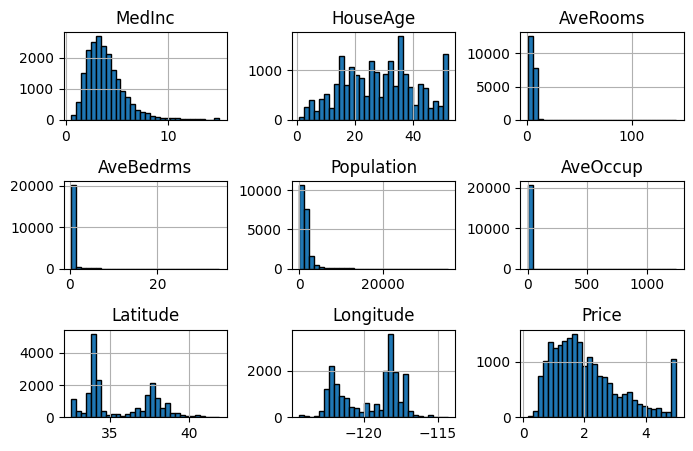

In [19]:
dataset.hist(figsize=(8, 5), bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)


**Findings**
1. The median income is a distribution with a long tail. It means that the salary of people is more or less normally distributed but there is some people getting a high salary.
2. Regarding the average house age, the distribution is more or less uniform.
3. The target distribution has a long tail as well. In addition, we have a threshold-effect for high-valued houses: all houses with a price above 5 are given the value 5.

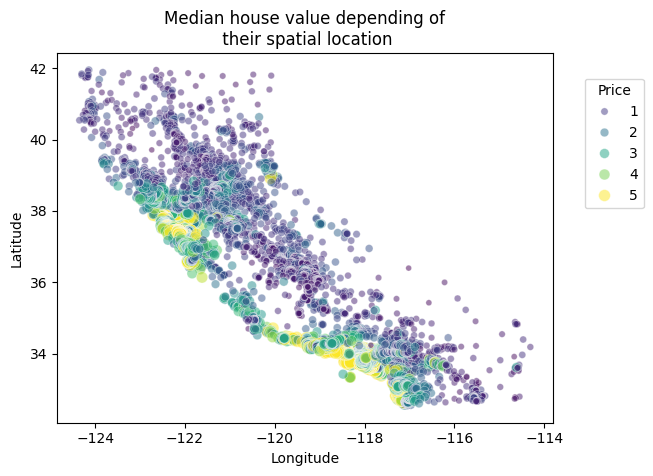

In [20]:
sns.scatterplot(
    data=dataset,
    x="Longitude",
    y="Latitude",
    size="Price",
    hue="Price",
    palette="viridis",
    alpha=0.5,
)
plt.legend(title="Price", bbox_to_anchor=(1.05, 0.95), loc="upper left")
_ = plt.title("Median house value depending of\n their spatial location")

Just compare with actual california map

If you are not familiar with the state of California, it is interesting to notice that **all datapoints show a graphical representation of this state**. We note that the high-valued houses will be located on the coast, where the big cities from California are located: San Diego, Los Angeles, San Jose, or San Francisco.

We can do a random subsampling to have less data points to plot but that could still allow us to see these specificities.

In [21]:
rng = np.random.RandomState(0)
indices = rng.choice(
    np.arange(dataset.shape[0]), size=500, replace=False
)

In [22]:
columns_drop = ["Longitude", "Latitude"]
subset = dataset.iloc[indices].drop(columns=columns_drop)
# Quantize the target and keep the midpoint for each interval
subset["Price"] = pd.qcut(subset["Price"], 6, retbins=False)
subset["Price"] = subset["Price"].apply(lambda x: x.mid)

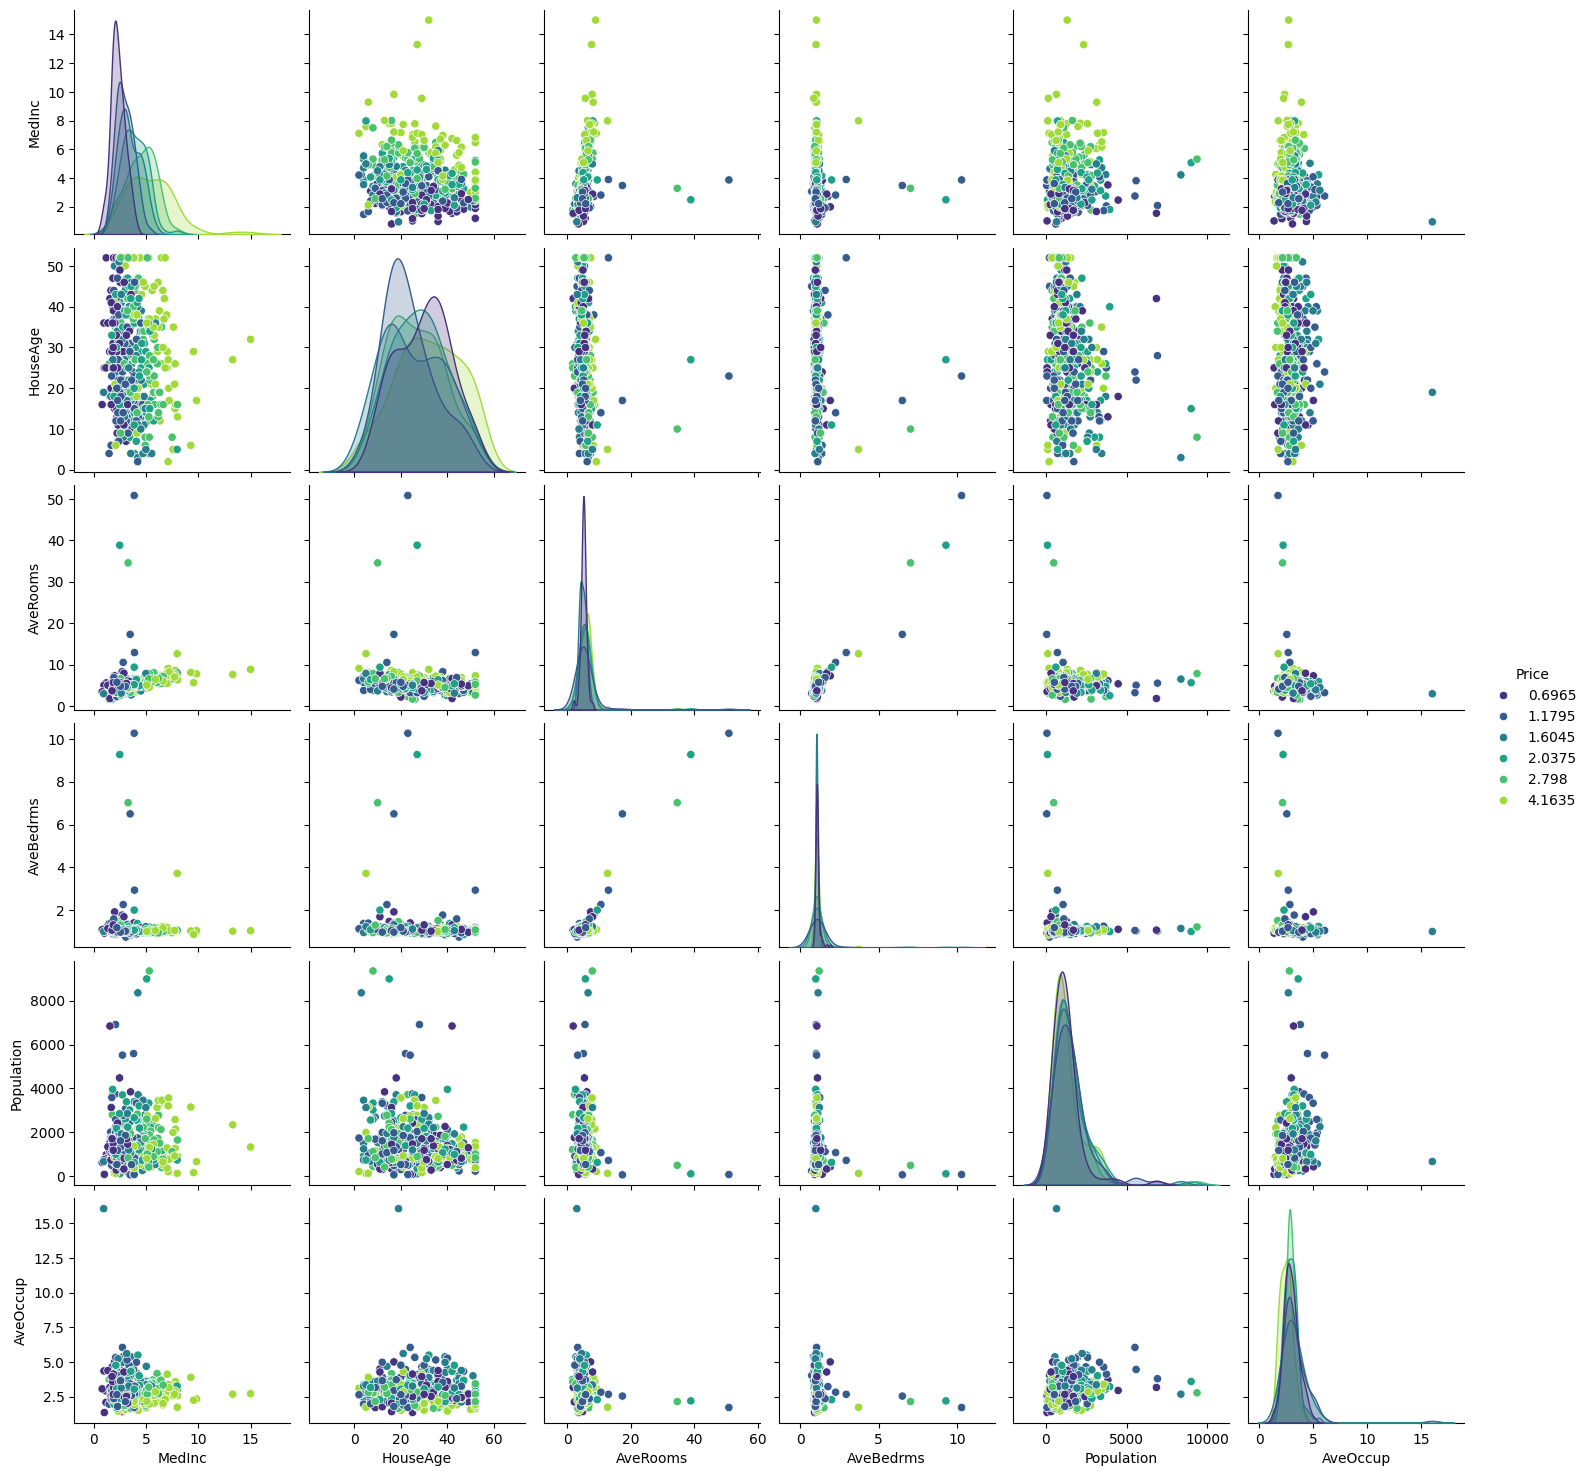

In [127]:
_ = sns.pairplot(data=subset, hue="Price", palette="viridis")

In [23]:
dataset.corr()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
MedInc,1.000000,-0.119034,0.326895,-0.062040,0.004834,0.018766,-0.079809,-0.015176,0.688075
HouseAge,-0.119034,1.000000,-0.153277,-0.077747,-0.296244,0.013191,0.011173,-0.108197,0.105623
AveRooms,0.326895,-0.153277,1.000000,0.847621,-0.072213,-0.004852,0.106389,-0.027540,0.151948
AveBedrms,-0.062040,-0.077747,0.847621,1.000000,-0.066197,-0.006181,0.069721,0.013344,-0.046701
Population,0.004834,-0.296244,-0.072213,-0.066197,1.000000,0.069863,-0.108785,0.099773,-0.024650
AveOccup,0.018766,0.013191,-0.004852,-0.006181,0.069863,1.000000,0.002366,0.002476,-0.023737
Latitude,-0.079809,0.011173,0.106389,0.069721,-0.108785,0.002366,1.000000,-0.924664,-0.144160
Longitude,-0.015176,-0.108197,-0.027540,0.013344,0.099773,0.002476,-0.924664,1.000000,-0.045967
Price,0.688075,0.105623,0.151948,-0.046701,-0.024650,-0.023737,-0.144160,-0.045967,1.000000


We can confirm that some features have extreme values (outliers?). We can as well see that the median income is helpful to distinguish high-valued from low-valued houses.
Thus, creating a predictive model, we could expect the longitude, latitude, and the median income to be useful features to help at predicting the median house values.

In [26]:
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
# from sklearn.compose import TransformedTargetRegressor

In [25]:
features_for_log_transform = ['MedInc', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup'] # if required, we can go for standardization later
features_for_standard_scaling = ['HouseAge', 'Latitude', 'Longitude']

In [84]:
# Using np.log1p (log(1+x)) is safer as it avoids log(0) errors.
log_pipeline = make_pipeline(
    FunctionTransformer(np.log1p,feature_names_out='one-to-one'),
    StandardScaler()
)


# 3. Use ColumnTransformer to apply different transformers to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('log_transform', log_pipeline, features_for_log_transform),
        ('standard_scale', StandardScaler(), features_for_standard_scaling)
    ],
    remainder='passthrough'  # Use 'passthrough' if there are other columns you want to keep
)

sklearn.linear_model.SGDRegressor (loss='squared_error',penalty='l2', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=1000, tol=0.001, shuffle=True, verbose=0, epsilon=0.1, random_state=None, learning_rate='invscaling', eta0=0.01, power_t=0.25, early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, warm_start=False, average=False)

In [85]:
model_pipeline = make_pipeline(
    preprocessor,
    SGDRegressor(random_state=42)
)

In [ ]:
# model1 = make_pipeline(StandardScaler(), SGDRegressor(random_state=42))
# model2 = make_pipeline(RobustScaler(),SGDRegressor(random_state=42))

Checkpoint

In [ ]:
# # This will apply np.log1p to y before training and np.expm1 to the predictions
# regr_trans = TransformedTargetRegressor(
#     regressor=model1,
#     func=np.log1p,
#     inverse_func=np.expm1
# )
# # Note: np.log1p(x) is log(1+x), which is safer than np.log if y has zeros.

Checkpoint

In [ ]:
# param_grid = {
#     'regressor__sgdregressor__penalty': ['l2', 'l1','elasticnet'],
#     'regressor__sgdregressor__alpha': np.logspace(-4, 0, num=20),
#     'regressor__sgdregressor__eta0': [0.001, 0.01]
# }

In [ ]:
# from sklearn.model_selection import GridSearchCV

# # Set up the grid search with 5-fold cross-validation
# # grid_search = GridSearchCV(regr_trans, param_grid, cv=5, n_jobs=-1, verbose=2)
# grid_search = GridSearchCV(model2,param_grid,cv=5, verbose = 2,n_jobs=-1)


SGDRegressor model was able to explain about 45% of the variance in the California housing prices.

Splitting dataset

In [86]:
X = pd.DataFrame(housing.data, columns=housing.feature_names) 
y = housing.target

In [87]:
X_train,X_test,y_train,y_test = tts(X,y,test_size=0.2,random_state=42)

In [88]:
print("Fitting the preprocessor...")
model_pipeline.named_steps['columntransformer'].fit(X_train)
print("Preprocessor fitting complete.")

Fitting the preprocessor...
Preprocessor fitting complete.


In [89]:
def create_mini_batches(X, y, batch_size):
    # Ensure y is a numpy array for consistent indexing
    y = np.array(y)
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    for start_idx in range(0, X.shape[0] - batch_size + 1, batch_size):
        excerpt = indices[start_idx:start_idx + batch_size]
        yield X.iloc[excerpt], y[excerpt]

In [90]:
n_epochs = 10
batch_size = 10

In [91]:
for epoch in range(n_epochs):
    for X_batch, y_batch in create_mini_batches(X_train, y_train, batch_size):
        # 3a & 3b: Manually transform the current batch
        X_batch_processed = model_pipeline.named_steps['columntransformer'].transform(X_batch)
        
        # 3c & 3d: Access the regressor and call partial_fit
        model_pipeline.named_steps['sgdregressor'].partial_fit(X_batch_processed, y_batch)

In [92]:
y_train_pred = model_pipeline.predict(X_train)

In [93]:
mae = mean_absolute_error(y_train, y_train_pred)
mse = mean_squared_error(y_train, y_train_pred)
rmse = np.sqrt(mse) # Calculate RMSE from MSE
r2_train = r2_score(y_train, y_train_pred)

In [94]:
print("--- Model Performance Metrics ---")
print(f"R² Score: {r2_train:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

--- Model Performance Metrics ---
R² Score: 0.6284
Mean Absolute Error (MAE): 0.5295
Mean Squared Error (MSE): 0.4967
Root Mean Squared Error (RMSE): 0.7048


*R^2 = 1 - SSR/SST*

where SSR = sum of squares of residuals AND SST = Total sum of squares 

In [65]:
# score = model_pipeline.score(X_test, y_test)
# print(f"{n_epochs}, {batch_size}, Model score on test data: {score:.4f}")

In [66]:
# param = model_pipeline.get_params
# print(param)

In [38]:
# grid_search.fit(X_train, y_train)

In [44]:
# y_train_pred = grid_search.predict(X_train)

In [49]:
# r2_train = r2_score(y_train, y_train_pred)
# mse_train = mean_squared_error(y_train, y_train_pred)
# rmse_train = np.sqrt(mse_train)

In [50]:
# print("--- Evaluation Metrics on the Training Set ---")
# print(f"R-squared (R²): {r2_train:.4f}")
# print(f"Mean Squared Error (MSE): {mse_train:.4f}")
# print(f"Root Mean Squared Error (RMSE): {rmse_train:.4f}")

In [51]:
# print(grid_search.best_params_)

**Distribution of Residuals**

In [95]:
residuals=y_train-y_train_pred

In [53]:
# residuals

 1. Linearity and 
 2. Homoscedasticity (checked with the same plot)

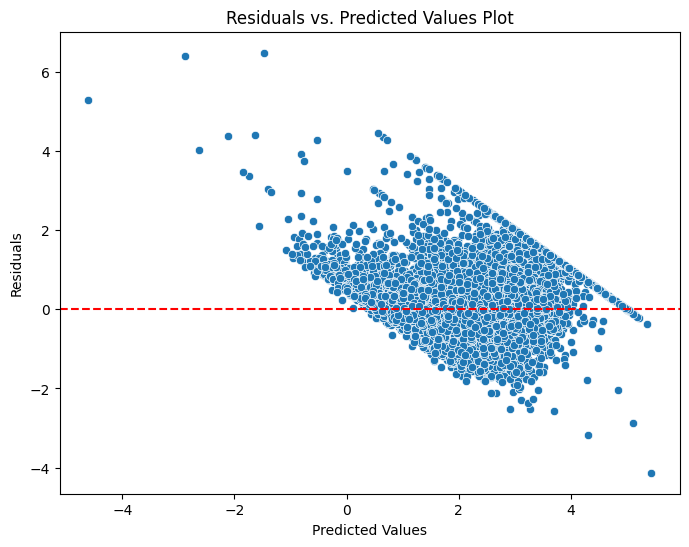

In [96]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_train_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs. Predicted Values Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

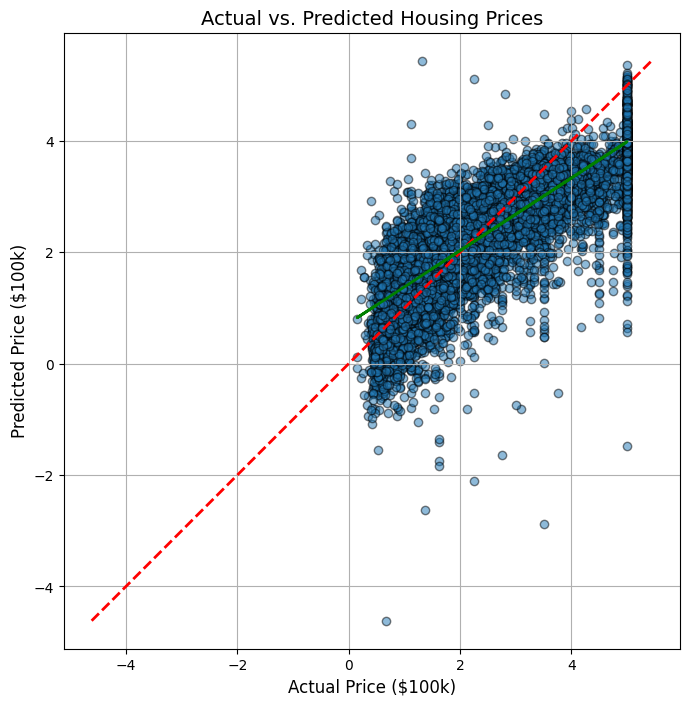

In [97]:
fig, ax = plt.subplots(figsize=(8, 8))

# 2. Create the scatter plot
ax.scatter(y_train, y_train_pred, alpha=0.5, edgecolors='k')

# 3. Create the 45-degree diagonal line for reference
# This line represents a perfect prediction (y_pred = y_test)
line_min = min(y_train.min(), y_train_pred.min())
line_max = max(y_train.max(), y_train_pred.max())
ax.plot([line_min, line_max], [line_min, line_max], 'r--', lw=2)
m, b = np.polyfit(y_train, y_train_pred, 1)

# Use the slope and intercept to plot the line
ax.plot(y_test, m * y_test + b, color='green', lw=2, label='Regression Line')
# 4. Add labels and a title for clarity
ax.set_xlabel("Actual Price ($100k)", fontsize=12)
ax.set_ylabel("Predicted Price ($100k)", fontsize=12)
ax.set_title("Actual vs. Predicted Housing Prices", fontsize=14)

# 5. Add a grid for better readability
ax.grid(True)
ax.set_aspect('equal', adjustable='box') # Makes the plot square

# 6. Show the plot
plt.show()

In [98]:
print(m,b)

0.6521647270158109 0.7267379088363001


3. Normality of Errors

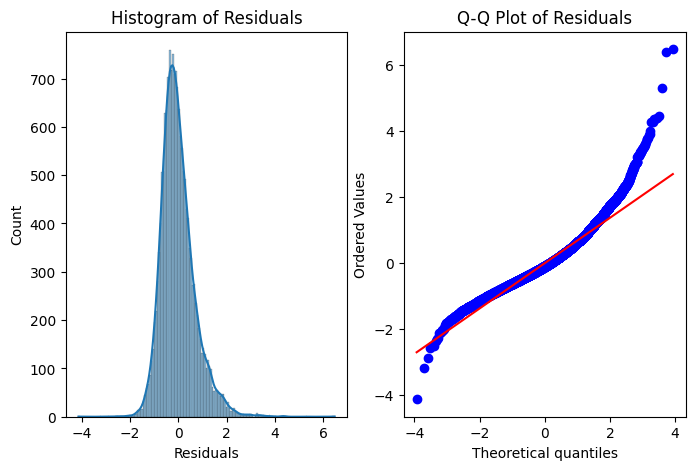

In [99]:
plt.figure(figsize=(8, 5))

# Histogram of residuals
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')

# Q-Q Plot of residuals
plt.subplot(1, 2, 2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

In [100]:
def VIF(r2_score):
    return 1/(1-r2_score)

In [71]:
# y_test_pred = grid_search.predict(X_test)

# # Calculate metrics
# r2_test = r2_score(y_test, y_test_pred)
# rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

In [72]:
# print("\n--- Evaluation Metrics on the Test Set ---")
# print(f"R-squared (R²): {r2_test:.4f}")
# print(f"Root Mean Squared Error (RMSE): {rmse_test:.4f}")

In [73]:
# print("--- Evaluation Metrics on the Training Set ---")
# print(f"R-squared (R²): {r2_train:.4f}")
# print(f"Mean Squared Error (MSE): {mse_train:.4f}")
# print(f"Root Mean Squared Error (RMSE): {rmse_train:.4f}")

4. No or Minimal Multicollinearity

If the value of VIF is -

- 1 => not correlated. Multicollinearity doesn't exist.
- Between 1 and 5 => moderately correlated. Low multicollinearity exists.
- Greater than 5 => Highly correlated. High Multicollinearity exists.

In [101]:
VIF_train = VIF(r2_train)
# VIF_test = VIF(r2_test)
print("---Variance Inflation Factor--")
print(f"On Train:{VIF_train:.4f} ")
# print(f"On Test:{VIF_test:.4f}")

---Variance Inflation Factor--
On Train:2.6913 


In [102]:
final_regressor = model_pipeline.named_steps['sgdregressor']
weights = final_regressor.coef_
preprocessor = model_pipeline.named_steps['columntransformer']
final_feature_names = preprocessor.get_feature_names_out()
feature_weights = pd.Series(weights, index=final_feature_names)
sorted_feature_weights = feature_weights.abs().sort_values(ascending=False)
print("--- Most Influential Features ---")
print(feature_weights[sorted_feature_weights.index])


--- Most Influential Features ---
standard_scale__Latitude    -0.862895
log_transform__MedInc        0.851873
standard_scale__Longitude   -0.807400
log_transform__AveOccup     -0.257345
log_transform__AveBedrms     0.177583
log_transform__AveRooms     -0.172514
standard_scale__HouseAge     0.142338
log_transform__Population    0.031270
dtype: float64


In [103]:
X_train_scaled = preprocessor.transform(X_train)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=final_feature_names)
X_train_scaled_df.describe()

,log_transform__MedInc,log_transform__AveRooms,log_transform__AveBedrms,log_transform__Population,log_transform__AveOccup,standard_scale__HouseAge,standard_scale__Latitude,standard_scale__Longitude
count,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04
mean,-4.518350e-16,-1.521178e-16,7.108870e-16,3.287637e-16,2.569004e-16,-1.678244e-17,3.385750e-15,1.776787e-15
std,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00
min,-3.097668e+00,-5.155781e+00,-4.237710e+00,-7.676745e+00,-3.931408e+00,-2.190766e+00,-1.447697e+00,-2.377207e+00
25%,-6.877598e-01,-5.789289e-01,-3.425676e-01,-4.828844e-01,-5.680286e-01,-8.417859e-01,-8.018107e-01,-1.110749e+00
50%,-1.294369e-02,1.060367e-03,-1.415219e-01,4.928517e-02,-5.685317e-02,3.108328e-02,-6.473597e-01,5.346501e-01
75%,6.520117e-01,5.376434e-01,9.303274e-02,5.815604e-01,4.881786e-01,6.658972e-01,9.720351e-01,7.839530e-01
max,3.487932e+00,1.352384e+01,2.430153e+01,4.703044e+00,2.750699e+01,1.856173e+00,2.951816e+00,2.628794e+00


**Comparing training and testing metrics:**
*No signs of overfitting*


**Wrap Up**

In [107]:
import pickle
model_filename = 'housing_price_predictor.pkl'

print(f"\nSaving model to {model_filename}...")

# Open the file in write-binary ('wb') mode and save the model
with open(model_filename, 'wb') as file:
    pickle.dump(model_pipeline, file)

print("Model saved successfully!")


Saving model to housing_price_predictor.pkl...
Model saved successfully!


In [104]:
# best_sgd_model = grid_search


In [105]:
# trained_pipeline = best_sgd_model.best_estimator_.regressor_
# final_sgd_regressor = trained_pipeline.named_steps['sgdregressor']
# coefficients = final_sgd_regressor.coef_

In [106]:
# coef_series = pd.Series(coefficients, index=housing.feature_names)
# sorted_coefficients = coef_series.sort_values(ascending=False)

# print("--- Model Coefficients ---")
# print(sorted_coefficients)

**Findings:**
- Positive Coefficients: A positive coefficient means that as the feature's value increases, the model's prediction for **the log of the house price** also increases.
**MedInc (Median Income)** will almost certainly have the largest positive coefficient. This means higher income in a block group is the strongest predictor of higher house prices.
- Negative Coefficients: A negative coefficient means that as the feature's value increases, the model's prediction for the log of the house price decreases. You might see features like Latitude or Longitude with large negative values, which can be harder to interpret individually but capture geographic trends (e.g., prices decrease as you move in a certain direction).
- Coefficients Close to Zero: The L1 penalty  might have pushed the coefficients of less important features to be exactly zero. Any feature with a coefficient of 0.0 was effectively removed by the model because it was not considered useful for making predictions. 

In [115]:
p1 = model_pipeline.predict(dataset.loc[[1]])
p1

array([3.94096868])

In [116]:
print(f"diff with original sample's price: {p1-dataset['Price'][1]}")

diff with original sample's price: [0.35596868]


**Saving the model**

In [ ]:
# import pickle

In [ ]:
# pickle.dump(best_sgd_model,open('tunedsgdreg.pkl','wb'))

In [ ]:
# pickled_model=pickle.load(open('tunedsgdreg.pkl','rb'))

In [117]:
%whos

Variable                        Type                 Data/Info
--------------------------------------------------------------
ColumnTransformer               ABCMeta              <class 'sklearn.compose._<...>ormer.ColumnTransformer'>
FunctionTransformer             type                 <class 'sklearn.preproces<...>mer.FunctionTransformer'>
RobustScaler                    type                 <class 'sklearn.preproces<...>sing._data.RobustScaler'>
SGDRegressor                    ABCMeta              <class 'sklearn.linear_mo<...>c_gradient.SGDRegressor'>
StandardScaler                  type                 <class 'sklearn.preproces<...>ng._data.StandardScaler'>
VIF                             function             <function VIF at 0x000001ED1B3F2340>
VIF_train                       float                2.6913217965145084
X                               DataFrame            Shape: (20640, 8)
X_batch                         DataFrame            Shape: (10, 8)
X_batch_processed           